## A CNN Dermoscopic Image Classification Practicum: HAM10000

### Model Build Objectives

There are three main objectives of this project involving building a Keras sequential image classification model on a laptop.<br>

But first, let’s look at the issues this data and available resources presents.  <br>
The major problem is that the data is heavily biased in favor of a single class (Melanocytic nevi [nv]) of seven, which accounts for 67% of the data, shown in 3.1 Cell Type Count.  Other factors include similarities in color and a somewhat small dataset size for image classification.  In addition, the model architecture and subsequent performance is affected by image down-sizing [from 600x400 to 160x120] resolution and a limited amount of resource memory (i.e., compute power). <br>

The objectives are: <br>
    1) to significantly reduce or eliminate overfitting, <br>
    2) reach at least 80% test accuracy without violating the first objective, and <br>
    3) build a model that can work with limited resources while reaching objective 2.  <br>

The model is to be run using a GTX 1070 GPU with 6.1 GB of available memory.  Although I could use the CPU in which there is considerably more memory, time is limited and testing a wide variety of model builds using the CPU is not a viable alternative. 

## Table of Contents 
1. Load Libraries <br>
2. Read & Process Data<br>
   2.1 Look inside HAM1000 directory<br>
   2.2 Read metadata and encode lables<br>
3. Merge image folders and create lesion type dictionary<br>
4. Add New Columns
5. Clean Data<br>
   5.2 Check for missing values indicated in ham_df.info()<br>
   5.3 Use mean of age to fill age missing values<br>
6. Exploratory Data Analysis (EDA)<br>
   6.1 Cell Type Count<br>
   6.6 Lesion Type by Age and Sex<br>
7. Resize Images<br>
    7.1 Compare image size characteristics<br>
    7.2 Resize Images for Model Input<br>
    7.3 A sample of skin lesion images<br>
8. Preprocess<br>
    8.1 Train Test Validate<br>
      8.1.1 Split: train / test = 80 / 20<br>
      8.1.2 Change to a Numpy array<br>
      8.1.3 Standardize<br>
      8.1.4 One-hot encoding: Convert output to categorical crossentropy<br>
      8.1.5 Split: train / validation = 0.87 / 0.13<br>
      8.1.6 Reshape images to 3 dimensions<br>
9. Test Model (modelT)<br>
    9.1 Test Model Architecture<br>
    9.2 Set the learning rate reduction and add data augumentation to the Test M<br>
    9.2.1 Train modelT with Augmentation<br>
    9.2.2 Evaluate  modelT test Accuracy and Loss<br>
    9.2.3 Test Model Accuracy and Loss Plots after Augumentation<br>
10. Final Model<br>
     10.1 Table 1 (Scores all runs)<br>
     10.2 CNN Model Architecture<br>
     10.3 Set Learning Rate and Augmentation<br>
     10.4 Model Fit<br>
     10.5 Scoring<br>
     10.6 Accuracy and Loss Plots<br>
11. All 5 Model 4 Runs<br>

In [9]:
import tensorflow as tf
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print('TensorFlow Version: {}'.format(tf.__version__))

Default GPU Device: /device:GPU:0
TensorFlow Version: 2.0.0


 This notebook was run on a laptop with a GTX 1070 GPU
 
    GPU:0 with 6372 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1070, compute capability: 6.1)

# 1. Load Libraries

In [2]:
import numpy as np
np.random.seed(1236)

# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
import tensorflow as tf
tf.random.set_seed(1236)

In [3]:
# Use %matplotlib inline to enable effective coordination between Jupyter and matplotlib and display within the notebook
%matplotlib inline

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D #, GlobalAveragePooling2D
from keras import optimizers
from keras.optimizers import Adam  #, SGD
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_crossentropy
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau #,EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2 #, l1 
from keras import initializers #he_normal

Using TensorFlow backend.


In [4]:
import seaborn as sns
from PIL import Image
import sklearn as sk
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn import metrics
import shutil
import itertools
from glob import glob
from numpy.random import seed

import pydot
import time
import cv2 

In [5]:
import autoreload 

%load_ext watermark
%load_ext autoreload
%autoreload 2

%watermark -a 'WForsythe' -d -t -v -p numpy,pandas,keras,sklearn,tensorflow,seaborn,cv2

WForsythe 2020-02-22 14:36:10 

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
pandas 0.25.3
keras 2.3.1
sklearn 0.22.1
tensorflow 2.0.0
seaborn 0.9.0
cv2 4.2.0


# 2 Read & Process Data

**Data Sourced from:**
    * Author: Mader, K
    * Title: Skin Cancer MNIST: HAM10000, a large collection of multi-source dermatoscopic images of pigmented lesions
    * Date: 2019
    * Code version: n.a.
    * Availability: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

## 2.1 Look inside HAM1000 directory
    The only files and folders from the HAM10000 directory needed to complete this project were the two image folders and the metadata file. 

In [5]:
ham_folder = 'C:\HAM10000'
print(os.listdir(ham_folder))

['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']


## 2.2 Read metadata and encode lables
    This operation includes creating a new column with dx labels converted to class numbers.
    Most of the following script was available from multiple sources. 

In [6]:
# Source: https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb
# Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# Source: https://www.kaggle.com/hashbanger/skin-lesion-identification

metadata = pd.read_csv('C:\HAM10000\HAM10000_metadata.csv')
print(metadata.shape)

lab_enc = LabelEncoder()
lab_enc.fit(metadata['dx'])
LabelEncoder()
print(list(lab_enc.classes_))
 
metadata['label'] = lab_enc.transform(metadata["dx"]) # Converts labels to class numbers
metadata.head(15)

(10015, 7)
['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,2


# 3 Merge image folders and create lesion type dictionary

In [8]:
# Source: https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb
# Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# Source: https://www.kaggle.com/hashbanger/skin-lesion-identification

base_folder = os.path.join('..', ham_folder)

# Merge image folders HAM10000_images_part1 and HAM10000_images_part2  

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_folder, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# 4 Add New Columns
    

In [10]:
# Source: https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb
# Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy
# Source: https://www.kaggle.com/hashbanger/skin-lesion-identification

ham_df = pd.read_csv(os.path.join(base_folder, 'HAM10000_metadata.csv'))

# Create new columns
ham_df['path'] = ham_df['image_id'].map(imageid_path_dict.get) # Map image paths to image_ids
ham_df['cell_type'] = ham_df['dx'].map(lesion_type_dict.get) # create cell type column from dx with full class names
ham_df['cell_type_idx'] = pd.Categorical(ham_df['cell_type']).codes # Convert cell type to categorical 

In [11]:
ham_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\HAM10000\HAM10000_images_part_1\ISIC_002741...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\HAM10000\HAM10000_images_part_1\ISIC_002503...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\HAM10000\HAM10000_images_part_1\ISIC_002676...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\HAM10000\HAM10000_images_part_1\ISIC_002566...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\HAM10000\HAM10000_images_part_2\ISIC_003163...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,C:\HAM10000\HAM10000_images_part_2\ISIC_003308...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,C:\HAM10000\HAM10000_images_part_2\ISIC_003355...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,C:\HAM10000\HAM10000_images_part_2\ISIC_003353...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,C:\HAM10000\HAM10000_images_part_2\ISIC_003285...,Actinic keratoses,0


In [12]:
ham_df.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

# 5 Clean Data

## 5.1 

In [13]:
ham_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id        10015 non-null object
image_id         10015 non-null object
dx               10015 non-null object
dx_type          10015 non-null object
age              9958 non-null float64
sex              10015 non-null object
localization     10015 non-null object
path             10015 non-null object
cell_type        10015 non-null object
cell_type_idx    10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


## 5.2 Check for missing values indicated in ham_df.info()

In [14]:
ham_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

## 5.3 Use mean of age to fill age missing values

In [15]:
ham_df['age'].fillna((ham_df['age'].mean()), inplace=True)
ham_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

### 5.3.1 Re-check to make sure that all the data is present

In [16]:
ham_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id        10015 non-null object
image_id         10015 non-null object
dx               10015 non-null object
dx_type          10015 non-null object
age              10015 non-null float64
sex              10015 non-null object
localization     10015 non-null object
path             10015 non-null object
cell_type        10015 non-null object
cell_type_idx    10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


# 6 Exploratory Data Analysis (EDA)
Although exploratory data analysis (EDA) performed was wide ranging, the primary consideration was the relative differences between cell type counts.  

##### Figures script adapted from: 
https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html<br>
https://flynn.gg/blog/better-matplotlib-charts/<br>
https://seaborn.pydata.org/tutorial/categorical.html<br>
https://seaborn.pydata.org/examples/grouped_boxplot.html<br>

## 6.1 Cell Type Count

This image dataset is highly imbalanced with one class of seven, Melanocytic nevi, filling 67% of the space. Between the imbalance bias, resizing the image size from 650x450 to 160x120 (a 93% pixel count reduction), and image color similarity this classification problem is an especially difficult exercise regarding model accuracy.

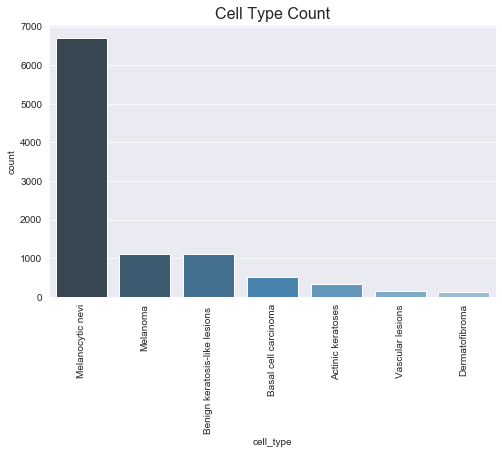

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


In [37]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.countplot(x = ham_df['cell_type'], #cell_type
                     order = ham_df['cell_type'].value_counts().index, #cell_type
                     palette= "Blues_d") #vlag   deep  rocket coolwarm rainbow Blues
plt.xticks(rotation = 90) 
plt.title('Cell Type Count',fontsize=16) 
plt.show()
print(ham_df['cell_type'].value_counts())

## 6.2 General Anatomy Site Count

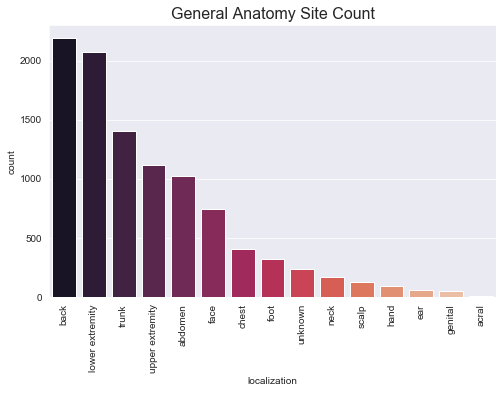

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64


In [83]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.countplot(x = ham_df['localization'], 
                     order = ham_df['localization'].value_counts().index, 
                     palette= "rocket")
plt.xticks(rotation = 90) 
plt.title('General Anatomy Site Count',fontsize=16)
plt.show()
print(ham_df['localization'].value_counts())

## 6.3 Distribution of Age

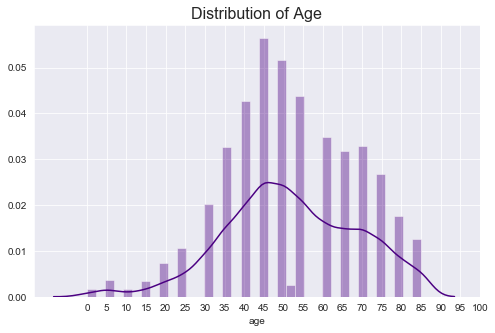

In [84]:
sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
plt.title('Distribution of Age',fontsize=16)
sns.distplot(ham_df['age'], color= 'indigo')
#plt.title('Overall Distribution')
plt.xticks(list(range(0,105,5)))

plt.show()

## 6.4 Age Distribution by Sex

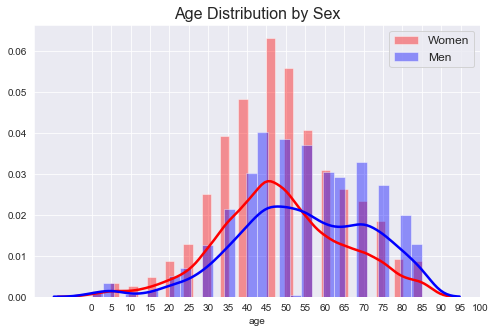

In [46]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.distplot(ham_df[ham_df['sex']=='female']['age'], 
             label='Women', 
             color="r",
             kde_kws=dict(linewidth=2.5))
sns.distplot(ham_df[ham_df['sex']=='male']['age'], 
             label='Men', 
             color="b",
             kde_kws=dict(linewidth=2.5))

plt.title('Age Distribution by Sex',fontsize=16)
plt.xticks(list(range(0,105,5)))
plt.legend(loc='upper right', fontsize='12')
plt.show()

## 6.5 Cell Type Count by Sex

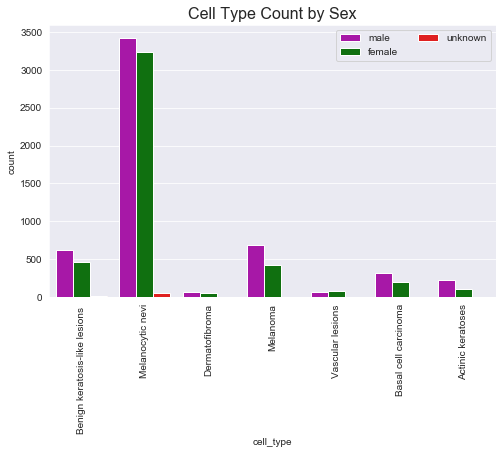

In [55]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.countplot(x='cell_type',  
              hue='sex', 
              palette=['m', 'g', 'r'],
              data=ham_df)
plt.legend(loc='upper right', ncol =2)  
plt.xticks(rotation = 90) 
plt.title('Cell Type Count by Sex',fontsize=16)
plt.show()

### 6.5.1
there are 57 unknown values for sex, but it's not an important factor for this project so it will be left alone. 

In [24]:
print(ham_df.groupby('sex')['age'].count())

sex
female     4552
male       5406
unknown      57
Name: age, dtype: int64


## 6.6 Lesion Type by Age and Sex

It looks from this plot like females tend to develop lesions at an earlier age than males for all categories. However, because the samples mean of age, 6.6.1, for females is 48.7 years while the mean for men is 54.5 years, which may account for difference.   

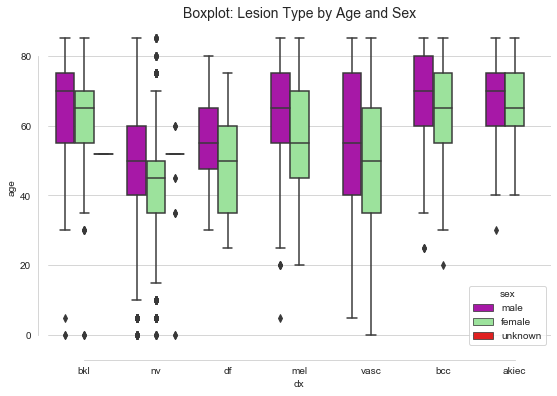

In [42]:
plt.figure(figsize=(9, 6))
sns.set_style("whitegrid")
sns.boxplot(x='dx', y='age',
            hue='sex', palette=['m', 'lightgreen', 'r'],
            data=ham_df)
plt.title('Boxplot: Lesion Type by Age and Sex',fontsize=14)
sns.despine(offset=10, trim=True)

### 6.6.1

In [21]:
ham_df.groupby('sex')['age'].mean()

sex
female     48.714292
male       54.542394
unknown    49.343858
Name: age, dtype: float64

## 6.7 Count Plot: Cell Type Count by Age

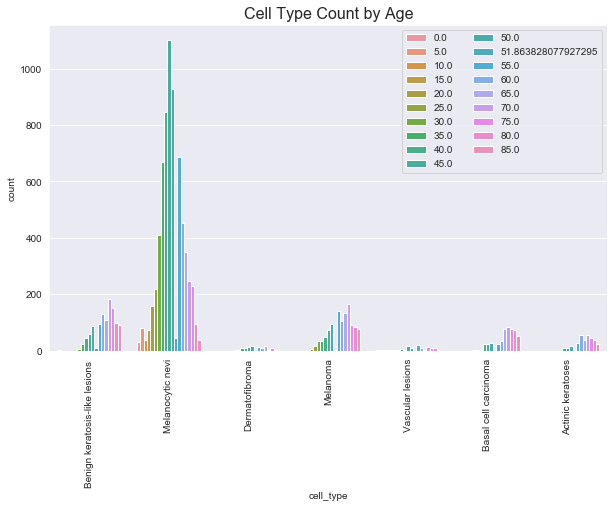

In [87]:
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.countplot(x='cell_type',  #cell_type
              hue='age',
              data=ham_df)
plt.legend(loc='upper right', ncol =2) # , framealpha=0.5 
plt.xticks(rotation = 90) 
plt.title('Cell Type Count by Age',fontsize=16)
plt.show()

## 6.8 Pairs Plot Cell Type by Age
http://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=plot

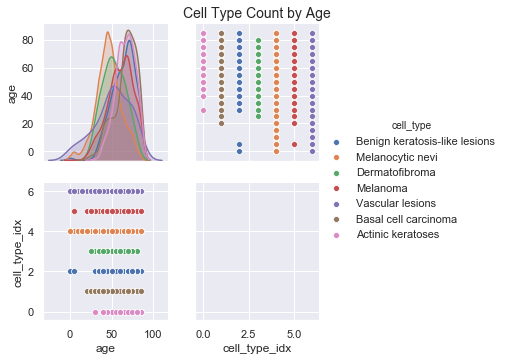

In [90]:
sns.set(style="darkgrid")
sns.pairplot(ham_df, hue="cell_type") 
plt.title('Cell Type Count by Age',fontsize=14)
plt.show()

## Seaborn Pairs Plot 
The following two cells saved here are for future reference. 
    * Author: Mader, K
    * Title: Dermatology MNIST: Loading and Processing
    * Date: 2019
    * Code version: n.a.
    * Availability: https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing

### Get and normalize color channel information

In [95]:
rgb_ham_df = ham_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_ham_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_ham_df.columns:
    rgb_ham_df[c_col] = rgb_ham_df[c_col]/gray_col_vec
rgb_ham_df['Gray_mean'] = gray_col_vec
rgb_ham_df.sample(10)

,Red_mean,Green_mean,Blue_mean,Gray_mean
2338,1.095006,0.865439,1.039555,173.623385
9036,1.150141,0.875402,0.974456,129.212778
5726,1.264748,0.849982,0.885269,173.883142
1591,1.192256,0.862743,0.945002,157.451441
5860,1.547749,0.708018,0.744233,121.210295
6260,1.314572,0.804819,0.880610,162.674201
856,1.214301,0.881434,0.904264,139.299271
1630,1.201904,0.913005,0.885091,166.863333
4567,1.252020,0.850425,0.897556,195.313646
8221,1.237955,0.836908,0.925137,168.624618


### Pairs Plot: Cell Type

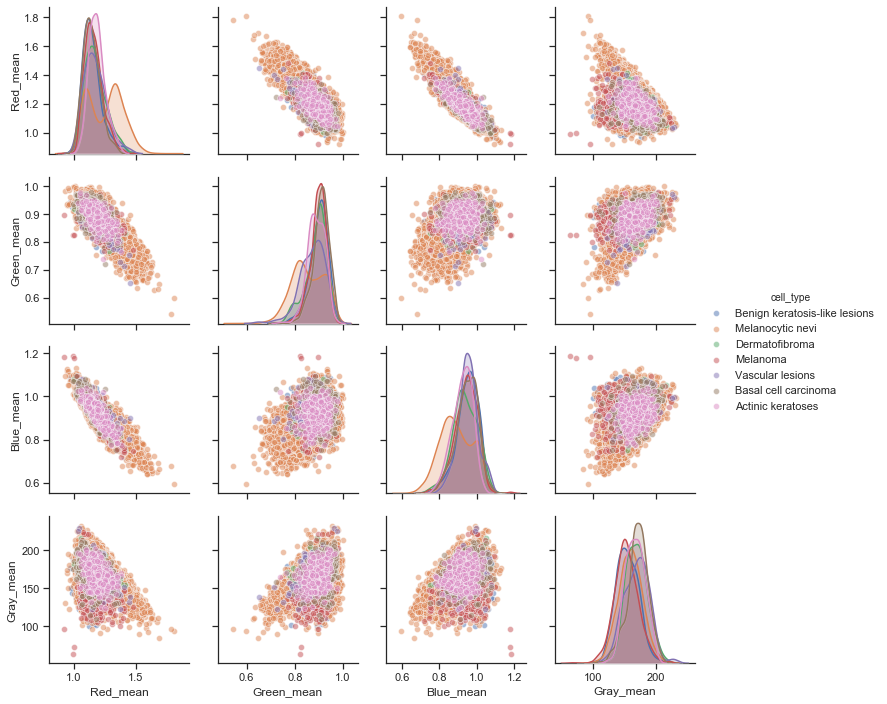

In [96]:
for c_col in rgb_ham_df.columns:
    ham_df[c_col] = rgb_ham_df[c_col].values
sns.pairplot(ham_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']], 
             hue='cell_type', plot_kws = {'alpha': 0.5})

# 7 Resize Images

## 7.1 Compare image size characteristics 
     Compare resized image resolution:  600x450 vs. 160x120
The side-by-side image comparisons (7.1.1 and 7.1.2) shows some reduction in resolution.  How much of an affect using a 160x120 resized image compared to the original size had regarding test accuracy is undetermined.   

In [38]:
img_ISIC_0032258 = Image.open('C:\ham10000\HAM10000_images_part_2\ISIC_0032258.jpg')
img_ISIC_0032259 = Image.open('C:\ham10000\HAM10000_images_part_2\ISIC_0032259.jpg')
img_ISIC_0032258_160x120 = img_ISIC_0032258.resize((160,120), Image.ANTIALIAS)
img_ISIC_0032258_160x120.save('D:\MSDS692\img_ISIC_0032258_160x120.jpg')
img_ISIC_0032259_160x120 = img_ISIC_0032259.resize((160,120), Image.ANTIALIAS)
img_ISIC_0032259_160x120.save('D:\MSDS692\img_ISIC_0032259_160x120.jpg')

### 7.1.1 Image ISIC_0032258.jpg

RGB JPEG


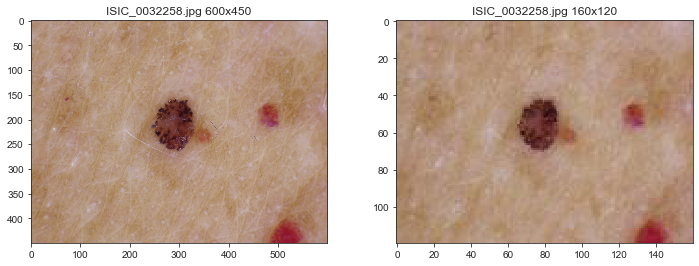

In [39]:
sns.set_style("ticks")
from PIL import Image
plt.figure(figsize=(12, 9))

plt.subplot(2,2,1)
imSize1 = Image.open('C:\ham10000\HAM10000_images_part_2\ISIC_0032258.jpg')
plt.title('ISIC_0032258.jpg 600x450')
plt.imshow(imSize1)

plt.subplot(2,2,2)
ISIC_0032258_160x120 = Image.open('D:\MSDS692\img_ISIC_0032258_160.jpg')
plt.title('ISIC_0032258.jpg 160x120')
plt.imshow(ISIC_0032258_160x120)

print(imSize1.mode, imSize1.format)
plt.show()

### 7.1.2 Image ISIC_0032259.jpg

RGB JPEG


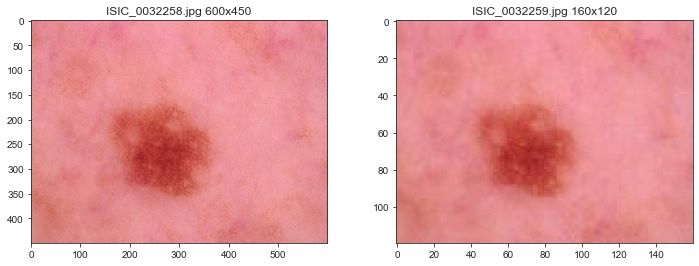

In [46]:
plt.figure(figsize=(12, 9))

plt.subplot(2,2,1)
imSize1 = Image.open('C:\ham10000\HAM10000_images_part_2\ISIC_0032258.jpg')
plt.imshow(imSize1)
plt.title('ISIC_0032258.jpg 600x450')
plt.imshow(imSize2)

plt.subplot(2,2,2)
ISIC_0032259_160x120 = Image.open('D:\MSDS692\img_ISIC_0032259_160x120.jpg')
plt.title('ISIC_0032259.jpg 160x120')
plt.imshow(ISIC_0032259_160x120)

print(imSize2.mode, imSize2.format)
plt.show()

## 7.2 Resize Images for Model Input
Image .resize(width, height) to produce input shape (height, width, channels)
<br>
Settled on image size **160x120**. <br>Tested other sizes listed below with *mixed* results. The (120, 160, 3) input shape was a compromise between speed, resolution, and memory limit. 

In [17]:
ham_df['image'] = ham_df['path'].map(lambda x: np.asarray(Image.open(x).resize((160,120)))) # 

In [ ]:
'''
##.resize(height, width)
#ham_df['image'] = ham_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
#ham_df['image'] = ham_df['path'].map(lambda x: np.asarray(Image.open(x).resize((128, 96))))
#ham_df['image'] = ham_df['path'].map(lambda x: np.asarray(Image.open(x).resize((180, 135)))) 
#ham_df['image'] = ham_df['path'].map(lambda x: np.asarray(Image.open(x).resize((240, 180))))
#ham_df['image'] = ham_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))
'''

In [18]:
print(ham_df['image'].map(lambda x: x.shape))

0        (120, 160, 3)
1        (120, 160, 3)
2        (120, 160, 3)
3        (120, 160, 3)
4        (120, 160, 3)
             ...      
10010    (120, 160, 3)
10011    (120, 160, 3)
10012    (120, 160, 3)
10013    (120, 160, 3)
10014    (120, 160, 3)
Name: image, Length: 10015, dtype: object


## 7.3 A sample of skin lesion images
Adapted from https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html

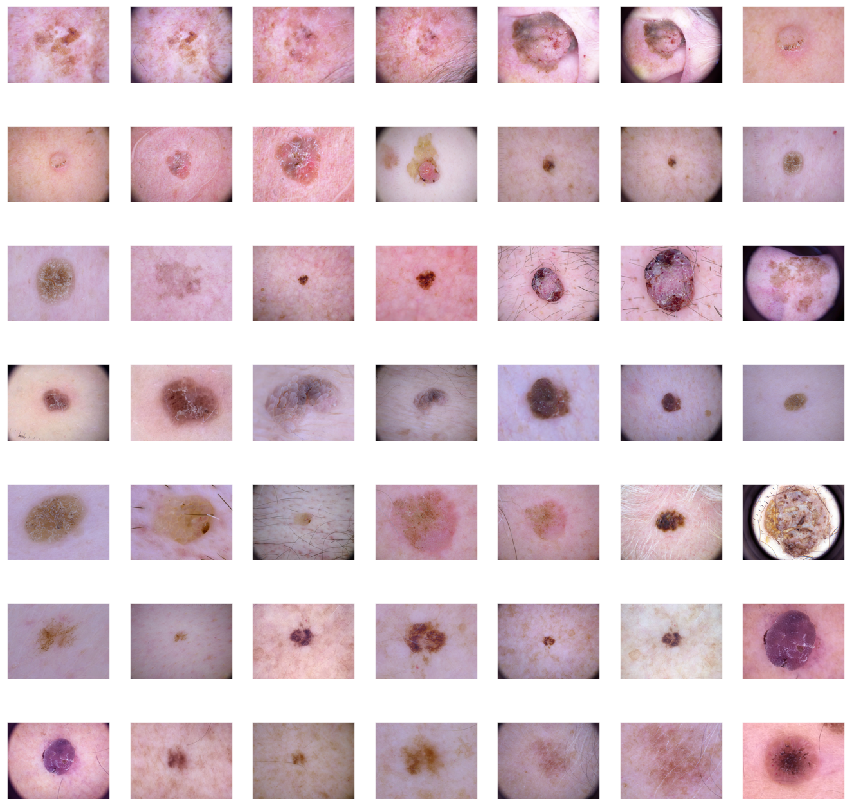

In [57]:
sns.set_style("ticks")
plt.figure(figsize=(15,15))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(ham_df['image'][i])
    
plt.show()

# Preprocess
The following processes were sourced or adapted from these sites and notebooks<br>
https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python<br>
https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb<br>
https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy<br>
https://www.kaggle.com/hashbanger/skin-lesion-identification<br>
https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/<br>

##### Normalize or standardize image pixels  
Feature-wise standardization was chosen over normalization. Although I tried normalizing also, I stuck with the choice that others had already applied.  Each are essentially equal when considering small gray scale images, however standardizing is probably a better choice for large color images.  Standardization uses mean and standard deviation statistics, whereas normalization rescales pixel values to a 0-1 range from a 0-255 range.

In [19]:
features=ham_df.drop(columns=['cell_type_idx'],axis=1)
target=ham_df['cell_type_idx']

## 8.1 Train Test Validate

### 8.1.1 Split: train / test = 80 / 20 

In [21]:
trainX, testX, trainY, testY = train_test_split(features, target, test_size=0.20,random_state=1234)

### 8.1.2 Change to a Numpy array

In [22]:
x_train = np.asarray(trainX['image'].tolist())
x_test = np.asarray(testX['image'].tolist())

### 8.1.3 Standardize

In [23]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std


### 8.1.4 One-hot encoding: Convert output to categorical crossentropy

In [24]:
y_train = to_categorical(trainY, 7)
y_test = to_categorical(testY, 7)

### 8.1.5 Split: train / validation = 0.87 / 0.13
     Chose validation size at 13% of train. Obtained slightly better results than using a 90/10 and other splits.

In [25]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.13, random_state = 2)

### 8.1.6 Reshape images to 3 dimensions 

In [26]:
x_train = x_train.reshape(x_train.shape[0], *(120, 160, 3))
x_test = x_test.reshape(x_test.shape[0], *(120, 160, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(120, 160, 3))

#### 8.1.6.1 Confirm shape

In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(x_validate.shape)

(6970, 120, 160, 3)
(6970, 7)
(2003, 120, 160, 3)
(1042, 120, 160, 3)


# 9 Test Model
   This section includes a test CNN model. The test model was provided primarily as an example starting point. 

## 9.1 Test Model Architecture

In [74]:
# CNN Model Architecture
input_shape = (120, 160, 3)
num_classes = 7

modelT = Sequential()
modelT.add(Conv2D(16, (3, 3), padding='same',input_shape=input_shape, activation='relu'))
modelT.add(BatchNormalization())
modelT.add(MaxPooling2D(2, 2))
modelT.add(Dropout(0.25))

modelT.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
modelT.add(BatchNormalization())
modelT.add(MaxPooling2D(2, 2))
modelT.add(Dropout(0.25))

modelT.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
modelT.add(BatchNormalization())
modelT.add(MaxPooling2D(2, 2))
modelT.add(Dropout(0.25))

modelT.add(Flatten())
modelT.add(Dense(128, activation='relu'))
modelT.add(BatchNormalization())
modelT.add(Dropout(0.5))

modelT.add(Dense(num_classes, activation='softmax'))

modelT.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])
modelT.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 120, 160, 16)      448       
_________________________________________________________________
batch_normalization_26 (Batc (None, 120, 160, 16)      64        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 80, 16)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 60, 80, 32)        4640      
_________________________________________________________________
batch_normalization_27 (Batc (None, 60, 80, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 40, 32)       

### 9.1.1 Test Model Train Fit 

In [76]:
Epochs=20
batchSize=64
t0=time.time()
# model fit

print('------------------------------------------')
print('Running Model T without data augmentation.')
print('------------------------------------------')
ModelT = modelT.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=Epochs, 
                    batch_size=batchSize, 
                    verbose=1)

print('------------------------------------------')
t1=time.time()
print(t1-t0," seconds")

------------------------------------------
Running Model T without data augmentation.
------------------------------------------
Train on 6970 samples, validate on 2003 samples
Epoch 1/20
6970/6970 [==============================] - 14s 2ms/step - loss: 1.7633 - accuracy: 0.4683 - val_loss: 2.4154 - val_accuracy: 0.6161
Epoch 2/20
6970/6970 [==============================] - 12s 2ms/step - loss: 1.1226 - accuracy: 0.6535 - val_loss: 3.5170 - val_accuracy: 0.4638
Epoch 3/20
6970/6970 [==============================] - 12s 2ms/step - loss: 0.8980 - accuracy: 0.7016 - val_loss: 3.5659 - val_accuracy: 0.5307
Epoch 4/20
6970/6970 [==============================] - 12s 2ms/step - loss: 0.7926 - accuracy: 0.7159 - val_loss: 3.4995 - val_accuracy: 0.5607
Epoch 5/20
6970/6970 [==============================] - 12s 2ms/step - loss: 0.7337 - accuracy: 0.7410 - val_loss: 4.1339 - val_accuracy: 0.5791
Epoch 6/20
6970/6970 [==============================] - 12s 2ms/step - loss: 0.6941 - accuracy: 0.

### 9.1.2Test Model Evaluation 

In [77]:
# Model T evaluation  
print('------------------------------------------')
print('Model T evaluation without data augumentation.')
print('------------------------------------------')
scores = modelT.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = modelT.evaluate(x_test, y_test, verbose=0)
print("Final loss: {0:.4f}".format(final_loss, final_acc))

------------------------------------------
Model T evaluation without data augumentation.
------------------------------------------
CNN Error: 25.01%
CNN Acc: 74.99%
Final loss: 0.8403


### 9.1.3 Test Model Accuracy and Loss Plots

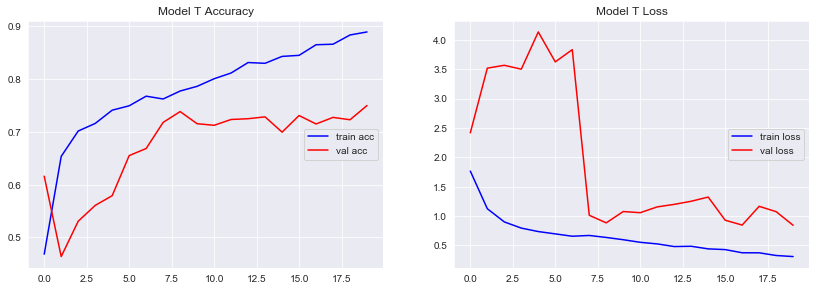

In [78]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(ModelT.history['accuracy'], 'b', label="Training accuracy")
plt.plot(ModelT.history['val_accuracy'], 'r', label="Validation accuracy")
plt.legend(['train acc', 'val acc'], loc='center right')
plt.title('Model T Accuracy')

plt.subplot(2,2,2)
plt.plot(ModelT.history['loss'], 'b', label= "Training loss")
plt.plot(ModelT.history['val_loss'], 'r', label="validation loss")
plt.legend(['train loss', 'val loss'], loc='center right')
plt.title('Model T Loss')
plt.show()

## 9.2 Set the learning rate reduction and add data augumentation to the Test Model

In [79]:
# Source: https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb
# Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=4, # 3
    verbose=1, 
    factor=0.5, 
    # factor=0.3,
    min_lr=0.0000001)

# data augmentation added to help reduce overfitting
train_datagen = ImageDataGenerator(
    rotation_range = 20, # 45, 90                 
    width_shift_range = 0.2,  # 0.1                
    height_shift_range = 0.2, # 0.1                                   
    shear_range = 0.1, # 0.2                 
    zoom_range = 0.1, # 0.2, 0.3                    
    horizontal_flip = True,
    #rescale = 1./255
    #vertical_flip=True,
)

### 9.2.1 Train modelT with Augmentation

In [80]:
# Source: https://github.com/00chengh/Skin-Cancer-HAM10000/blob/master/Final%20Capstone%20-%20Skin%20Cancer.ipynb
# Source: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

Epochs=20
batchSize=64
t0=time.time()

print('----------------------------------------------------------')
print('Running Model T [BatchNorm / Droput] with Augumentation.')
print('----------------------------------------------------------')

ModelT = modelT.fit(train_datagen.flow(x_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (x_validate,y_validate),  
                              verbose = 1, steps_per_epoch=x_train.shape[0] / batchSize, 
                              callbacks=[lr_reduction])

t1=time.time()
print(t1-t0," seconds")

----------------------------------------------------------
Running Model T [BatchNorm / Droput] with Augumentation.
----------------------------------------------------------
Epoch 1/20
109/108 [==============================] - 23s 207ms/step - loss: 0.8841 - accuracy: 0.7056 - val_loss: 0.7350 - val_accuracy: 0.7418
Epoch 2/20
109/108 [==============================] - 22s 201ms/step - loss: 0.7653 - accuracy: 0.7218 - val_loss: 0.6784 - val_accuracy: 0.7572
Epoch 3/20
109/108 [==============================] - 22s 198ms/step - loss: 0.7418 - accuracy: 0.7268 - val_loss: 0.8321 - val_accuracy: 0.7486
Epoch 4/20
109/108 [==============================] - 22s 200ms/step - loss: 0.7111 - accuracy: 0.7362 - val_loss: 0.6942 - val_accuracy: 0.7601
Epoch 5/20
109/108 [==============================] - 21s 197ms/step - loss: 0.7105 - accuracy: 0.7389 - val_loss: 0.7231 - val_accuracy: 0.7687
Epoch 6/20
109/108 [==============================] - 21s 197ms/step - loss: 0.7122 - accuracy: 0.73

### 9.2.3 Evaluate Test Model Test Accuracy and Loss 

In [81]:
# Model T evaluation  
print('-------------------------------------------------------------------')
print('Evaluation Scores: Model T [BatchNorm / Droput] with Augumentation.')
print('-------------------------------------------------------------------')
scores = modelT.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = modelT.evaluate(x_test, y_test, verbose=0)
print("Final loss: {0:.4f}".format(final_loss, final_acc))
print('------------------------------------------')

-------------------------------------------------------------------
Evaluation Scores: Model T [BatchNorm / Droput] with Augumentation.
-------------------------------------------------------------------
CNN Error: 24.61%
CNN Acc: 75.39%
Final loss: 0.6769
------------------------------------------


### 9.2.4 Test Model Accuracy and Loss Plots after Augmentation

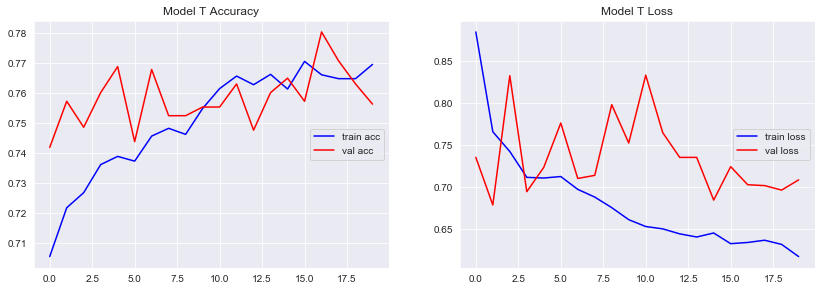

In [82]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(ModelT.history['accuracy'], 'b', label="Training accuracy")
plt.plot(ModelT.history['val_accuracy'], 'r', label="Validation accuracy")
plt.legend(['train acc', 'val acc'], loc='center right')
plt.title('Model T Accuracy')

plt.subplot(2,2,2)
plt.plot(ModelT.history['loss'], 'b', label= "Training loss")
plt.plot(ModelT.history['val_loss'], 'r', label="validation loss")
plt.legend(['train loss', 'val loss'], loc='center right')
plt.title('Model T Loss')
plt.show()

<br>
______________________________________________________________________________________________________________________________

# 10 Final Model
### Average CNN Score 80.14%
##### Showing Model 4 Run #2 
Shown in Table 1 are scores for separate runs and the average for each score type.  Score types included CNN (test) score, AUC Score, and f1 scores for model accuracy, melanoma, and basil cell carcinoma. CNN score is also referenced as the test score and as the classification score. CNN Scores and the Jaccard Index produced the exact same scores so I did not include Jaccard Scores, for example:<br>

from sklearn.metrics import jaccard_similarity_score<br>
jss = jaccard_similarity_score(y_true,y_pred)<br>
print("Jaccard similarity score: %.2f%%" % (round(jss,7)*100))

Tested multiple configurations including hyperparameters before settling on this final architecture and tuning.  This model, Model 4, was one of six seperate architectures attempted. Metrics included CNN (test) accuracy and loss, which was the primary metric, plus f1-scores in a classification report, AUC (area under curve) score, jaccard similarity score, and confusion matrix. The optimizer was Adam set at the default value and loss was categorical cross entropy. 

Model 4 input included 160x120 3 channel images resized from 600x450. This final model included 9 convolutions in 4 groups, a 2 dense group, flatten, and the output layer. Conv Group 1 had three convolutions: A slightly different approach than usual. Conv Groups 2, 3, and 4 each contained two convolutions. In addition, the input convolution (Conv layer 1) had 16 kernel filters while the following two convolutions in group 1 each included 32 kernel filters. For the dense layers 1024 kernels worked better than larger or smaller sized kernels. Each convolution layer included 3x3 filters, which is best to discern small and local features (Ramesh, 2018). 
<br>Also included were BatchNormalization, MaxPooling2D, and Dropout layers. An added kernel regulizer l2 set at 0.01 to help manage overfitting was added to each Conv2D, and to each Dense layer.  
    
CNN Scores were very close to one another. The best **CNN Score** was 80.38% (run #4) and the best **AUC Score** was 0.7872 (run #5). The CNN average was 0.8014 and the AUC was 0.7805. The average difference between test and AUC scores was 0.0209 or 2.6 %.  The area under curve may be a better indicator of how well of a fit the model is than the CNN score.

## 10.1 Table 1

In [6]:
import pandas as pd
scoresTable = pd.read_csv('D:\MSDS692\Scores.csv')
scoresTable

,Model Run,CNN Score,AUC Score,f1 Accuracy,f1 Melanoma,f1 Basil Cell
0,1,0.8033,0.7705,0.80.,0.54,0.61.
1,2,0.7988,0.7805,0.80.,0.51,0.61.
2,3,0.8038,0.7774,0.80.,0.59,0.60.
3,4,0.7998,0.7872,0.80.,0.54,0.58.
4,5,0.8013,0.7867,0.80.,0.55,0.62.
5,Average,0.8014,0.7805,0.80.,0.55,0.60.


## 10.2 CNN Model Architecture

In [28]:
from keras.regularizers import l2 #, l1

np.random.seed(168)
inputShape = (120, 160, 3)
num_classes = 7
kreg = l2(0.01) # adding a regularizer to a layer adds a new loss # 0.001 or 0.0001
#areg = l1(0.01)

def model4():
    ### Model 4
    ## A model with 9 convolutions in 4 groups, 
    ## A 2 dense group, a flatten, and an output layer
    ## Conv2D
        # Activation: relu
        # Padding: same except first Conv2D = valid
        # kernel_regularizer: l2 added to dense layers and some convolution layers
        # Batch Normalization added to each conv layers group
        # Max Pooling added to each conv layers group 
        # Dropout added to each group
    ## Output 
        # Batch Normalization
        # activation: Softmax
    ## Compile
        # Metric: Accuracy
        # Optimizer: Adam (default values)
        # Loss: categorical cross entropy 

    model = Sequential()
    
    # conv group 1
    model.add(Conv2D(16, (3, 3), padding='valid', input_shape=inputShape, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=kreg, activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=kreg, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    
    # conv group 2
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=kreg, activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=kreg, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    
    # conv group 3
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=kreg, activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=kreg, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    
    # conv group 4
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=kreg, activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=kreg, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))

    # flatten
    model.add(Flatten())
    
    # dense group
    model.add(Dense(1024, kernel_regularizer=kreg, activation='relu'))
    model.add(Dense(1024, kernel_regularizer=kreg, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25)) 
    
    # output 
    model.add(Dense(num_classes))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    # model compile
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return model

model4 = model4()
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 160, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 160, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 160, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 160, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 80, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 32)       

## 10.3 Set Learning Rate and Augmentation

In [29]:
lrReduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, # patience=3 gave slightly better results than 4, 2, 5
    verbose=1, 
    factor=0.5, 
    #factor=0.3,
    min_lr=0.0000001
)

trainDatagen = ImageDataGenerator(
    rotation_range = 20, # Tried a variety of rotations but made little difference                 
    width_shift_range = 0.1,  # 0.2                
    height_shift_range = 0.1, # 0.2                                     
    #shear_range = 0.1,  # 0.2                
    zoom_range = 0.1, # 0.2, 0.3  
    horizontal_flip = True,
    #vertical_flip = True # tended to add a bit more overfitting
)

trainDatagen.fit(x_train) # fit the training data in order to augment.

## 10.4 Model Fit 

In [30]:
epochs = 50 # Begins to flatten at around 42 epochs, tried 40 and 70
batchSize = 128 # A batch size of 128 worked better than 32 or 64
t0=time.time()

print('------------------------------------------------')
print('Running Model 4 - Data Augumentation Included.')
print('------------------------------------------------')

Model4 = model4.fit_generator(trainDatagen.flow(x_train,y_train, batch_size=batchSize),
                              epochs = epochs, validation_data = (x_validate,y_validate),  
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batchSize, 
                              callbacks=[lrReduction])

t1=time.time()
print(t1-t0," seconds")

------------------------------------------------
Running Model 4 - Data Augumentation Included.
------------------------------------------------
Epoch 1/50
54/54 [==============================] - 37s 680ms/step - loss: 5.2191 - accuracy: 0.5551 - val_loss: 4.2122 - val_accuracy: 0.6747
Epoch 2/50
54/54 [==============================] - 28s 525ms/step - loss: 3.7633 - accuracy: 0.6511 - val_loss: 3.0765 - val_accuracy: 0.6747
Epoch 3/50
54/54 [==============================] - 28s 526ms/step - loss: 2.8257 - accuracy: 0.6814 - val_loss: 2.4672 - val_accuracy: 0.6747
Epoch 4/50
54/54 [==============================] - 29s 529ms/step - loss: 2.2761 - accuracy: 0.7021 - val_loss: 2.1152 - val_accuracy: 0.6747

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
54/54 [==============================] - 28s 527ms/step - loss: 1.9846 - accuracy: 0.7219 - val_loss: 1.9570 - val_accuracy: 0.6737
Epoch 6/50
54/54 [==============================] - 29s 531

## Scoring

### 10.5.1 Assess Accuracy and Loss Scores
I decided to present the lowest scored model run of five runs rather than the highest scored run.

In [31]:
print('-----------------------------------')
print('Model 4 Accuracy and Loss Scores')
print('-----------------------------------')
scores = model4.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = model4.evaluate(x_test, y_test, verbose=1)
print("Final loss: {0:.4f}".format(final_loss, final_acc))
print('----------------------------------------')

-----------------------------------
Model 4 Accuracy and Loss Scores
-----------------------------------
CNN Error: 20.12%
CNN Acc: 79.88%
2003/2003 [==============================] - 3s 2ms/step
Final loss: 0.9667
----------------------------------------


### 10.5.2 Predict and Transform to One-hot

In [ ]:
y_pred = np.argmax(model4.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

### 10.5.3 Assign Target Names

In [ ]:
targetNames = ['Actinic keratoses', 'Basal cell carcinoma','Benign keratosis-like lesions', 
                'Dermatofibroma','Melanocytic nevi','Melanoma','Vascular lesions']

### 10.5.4 Process Classification Report
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [33]:
# Precision = True Positives / (True Positives + False Positives)
# Recall = True Positives / (True Positives + False Negatives)
# A balance between precison and recall: f1-score = 2*(1/((1/precision) + (1/recall)))

from sklearn.metrics import classification_report
print('Model 4 Classification Report')
print('----------------------------------------')

model4_report= classification_report(y_true, y_pred, target_names=targetNames)
print(model4_report)

Model 4 Classification Report
----------------------------------------
                               precision    recall  f1-score   support

            Actinic keratoses       0.55      0.48      0.51        60
         Basal cell carcinoma       0.61      0.55      0.58        97
Benign keratosis-like lesions       0.57      0.65      0.61       224
               Dermatofibroma       0.41      0.48      0.44        27
             Melanocytic nevi       0.88      0.94      0.91      1320
                     Melanoma       0.69      0.41      0.51       246
             Vascular lesions       0.96      0.79      0.87        29

                     accuracy                           0.80      2003
                    macro avg       0.67      0.61      0.63      2003
                 weighted avg       0.79      0.80      0.79      2003



### 10.5.5 Compute Area Under Curve (AUC)

In [34]:
'''
Author: Plog, E
Title: AUC ROC Curve Scoring Function for Multi-class Classification
Date: 2018
Code version: n.a.
Availability: https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
'''
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test1 = lb.transform(y_test) 
    y_pred1 = lb.transform(y_pred)
    return roc_auc_score(y_test1, y_pred1, average=average)

aucScore =multiclass_roc_auc_score(y_test, y_pred)
print('-----------------------------------')
print('Model 4 Area Under Curve')
print('-----------------------------------')
print("AUC: %.2f%%" % (aucScore*100)) # Add to show as a %

-----------------------------------
Model 4 Area Under Curve
-----------------------------------
AUC: 78.05%


### 10.5.6 Show Confusion Matrix
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

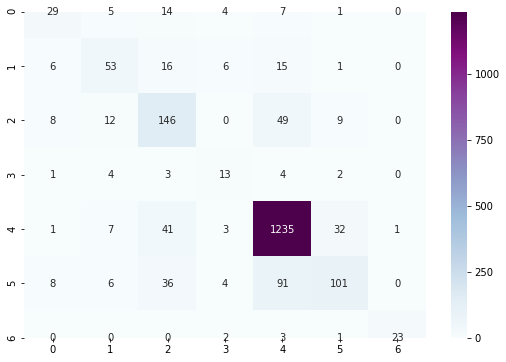

In [35]:
confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9,6))

sns.heatmap(confusion_mtx, annot=True, fmt='d',cmap=plt.cm.BuPu )
plt.show()

## 10.6 Accuracy and Loss Plots

Text(0.5, 1.0, 'Loss: Model 4')

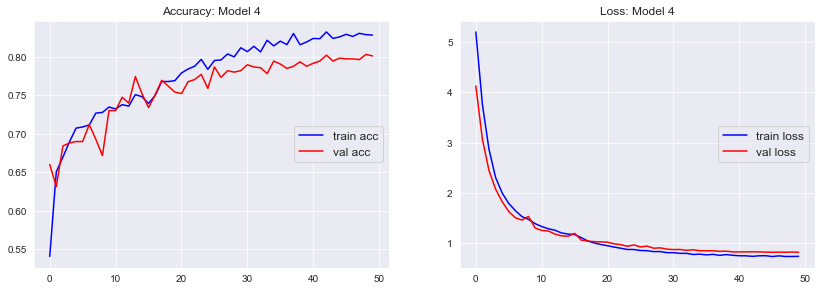

In [38]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(Model4.history['accuracy'], 'b', label="Training accuracy")
plt.plot(Model4.history['val_accuracy'], 'r', label="Validation accuracy")
plt.legend(['train acc', 'val acc'], loc='center right', fontsize='12')
plt.title('Accuracy: Model 4')

plt.subplot(2,2,2)
plt.plot(Model4.history['loss'], 'b', label= "Training loss")
plt.plot(Model4.history['val_loss'], 'r', label="validation loss")
plt.legend(['train loss', 'val loss'], loc='center right', fontsize='12')
plt.title('Loss: Model 4')

# 11 All Model 4 Runs

## Table 1

In [8]:
scoresTable = pd.read_csv('D:\MSDS692\Scores.csv')
scoresTable

,Model Run,CNN Score,AUC Score,f1 Accuracy,f1 Melanoma,f1 Basil Cell
0,1,0.8033,0.7705,0.80.,0.54,0.61.
1,2,0.7988,0.7805,0.80.,0.51,0.61.
2,3,0.8038,0.7774,0.80.,0.59,0.60.
3,4,0.7998,0.7872,0.80.,0.54,0.58.
4,5,0.8013,0.7867,0.80.,0.55,0.62.
5,Average,0.8014,0.7805,0.80.,0.55,0.60.


## Run 1

In [30]:
print('-----------------------------------')
print('Model 4 Accuracy and Loss Scores')
print('-----------------------------------')
scores = model4.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = model4.evaluate(x_test, y_test, verbose=1)
print("Final loss: {0:.4f}".format(final_loss, final_acc))
print('----------------------------------------')

-----------------------------------
Model 4 Accuracy and Loss Scores
-----------------------------------
CNN Error: 19.67%
CNN Acc: 80.33%
2003/2003 [==============================] - 3s 1ms/step
Final loss: 0.8574
----------------------------------------


## Run 2

In [31]:
print('-----------------------------------')
print('Model 4 Accuracy and Loss Scores')
print('-----------------------------------')
scores = model4.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = model4.evaluate(x_test, y_test, verbose=1)
print("Final loss: {0:.4f}".format(final_loss, final_acc))
print('----------------------------------------')

-----------------------------------
Model 4 Accuracy and Loss Scores
-----------------------------------
CNN Error: 20.12%
CNN Acc: 79.88%
2003/2003 [==============================] - 3s 2ms/step
Final loss: 0.9667
----------------------------------------


##  Run 3

In [35]:
print('-----------------------------------')
print('Model 4 Accuracy and Loss Scores')
print('-----------------------------------')
scores = model4.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = model4.evaluate(x_test, y_test, verbose=1)
print("Final loss: {0:.4f}".format(final_loss, final_acc))
print('----------------------------------------')

-----------------------------------
Model 4 Accuracy and Loss Scores
-----------------------------------
CNN Error: 19.62%
CNN Acc: 80.38%
2003/2003 [==============================] - 3s 1ms/step
Final loss: 0.9349
----------------------------------------


## Run 4

In [31]:
print('-----------------------------------')
print('Model 4 Accuracy and Loss Scores')
print('-----------------------------------')
scores = model4.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = model4.evaluate(x_test, y_test, verbose=1)
print("Final loss: {0:.4f}".format(final_loss, final_acc))
print('----------------------------------------')

-----------------------------------
Model 4 Accuracy and Loss Scores
-----------------------------------
CNN Error: 20.02%
CNN Acc: 79.98%
2003/2003 [==============================] - 3s 1ms/step
Final loss: 0.9164
----------------------------------------


## Run 5

In [31]:
print('-----------------------------------')
print('Model 4 Accuracy and Loss Scores')
print('-----------------------------------')
scores = model4.evaluate(x_test, y_test, verbose=2)

print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("CNN Acc: %.2f%%" % (scores[1]*100))

final_loss, final_acc = model4.evaluate(x_test, y_test, verbose=1)
print("Final loss: {0:.4f}".format(final_loss, final_acc))
print('----------------------------------------')

-----------------------------------
Model 4 Accuracy and Loss Scores
-----------------------------------
CNN Error: 19.87%
CNN Acc: 80.13%
2003/2003 [==============================] - 3s 2ms/step
Final loss: 0.8980
----------------------------------------
